In [24]:
import os
import sys

module_path = os.path.abspath(os.path.join('..')+'/src')
if module_path not in sys.path:
    sys.path.append(module_path)

# Ansatz

In this file, we illustrate the use of the Class ansatz.

In [88]:
import torch
from torch import nn
import warnings
import config

from math import sqrt

import matplotlib.pyplot as plt

In [89]:
import warnings
import torch
import torch as tc
from torch.func import jacfwd, vmap, grad,jacrev

class Ansatz(tc.nn.Module):
    
    def __init__(self, d, m, theta=None, kind='gaussian'):
        
        super().__init__()
        self.m = m       # model parameter 
        self.d = d       # dimension of b (same as x)
        
        # size of theta according to the the model
        if kind == 'gaussian':
            self.s = 2*m+m 
        else:
            self.s = 2*m+d*m
            warnings.warn("The type of network has not The theta parameter has not been initialized") 
        
        # Dictionary of models 
        methods = {
            'gaussian'        : self.gaussian_x,   # Eq. (16)
        }

        self.Theta = tc.rand(self.s,requires_grad=True) #if theta is None else theta
        self.theta = tc.nn.Parameter(tc.rand(self.s) if theta is None else theta)
        
        self.eval_x    = methods[kind]
        self.forward   = vmap(self.eval_x)
        
    def splitter_gaussian(self):
        c = self.theta[:self.m]
        b = self.theta[self.m: self.m+self.m*self.d ].reshape(self.m,self.d)
        w = self.theta[self.m+self.m*self.d:]
        return (c,b,w)
    
    def gaussian_x(self, x: tc.Tensor):
               
       # Input :  a SCALAR x of shape (0,)
       # Output : a SCALAR
        
        c, b, w = self.splitter_gaussian()
        return tc.sum(c*tc.exp(-w**2 *(x-b).T**2))  


    def forward(self, x):
        self.Theta = self.parameters()
        c,b,w = self.splitter_gaussian()
        #vect=lambda x: (c*tc.exp(-w**2*(x-b)**2)).sum()
        #return (c*tc.exp(-w**2*(x-b)**2)).sum()
        return tc.sum(c*tc.exp(-w**2*(x-b).T**2))
    
    def __call__(self, x):
        return self.forward(x)
        

We define the Anstazt

In [122]:
d = 1
m = 10
model = Ansatz(d,m)
x_train = torch.rand(10, 1)
print(x_train)
print(model(x_train))

tensor([[0.8801],
        [0.6379],
        [0.0542],
        [0.1879],
        [0.0124],
        [0.7967],
        [0.0512],
        [0.7548],
        [0.6241],
        [0.1126]])
tensor([5.0290, 5.4351, 5.4623, 5.5984, 5.4022, 5.1868, 5.4582, 5.2597, 5.4529,
        5.5325], grad_fn=<SumBackward1>)


In [123]:
x_domain = [0.0, 1.0]; n_points_x = 10
mesh_x = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True).reshape(n_points_x,1)
print(mesh_x)

print(model(mesh_x))

tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]], grad_fn=<ReshapeAliasBackward0>)
tensor([5.3829, 5.5309, 5.6193, 5.6472, 5.6163, 5.5306, 5.3961, 5.2203, 5.0115,
        4.7778], grad_fn=<SumBackward1>)


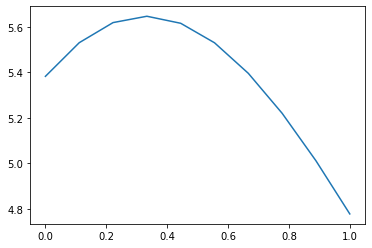

In [124]:
mesh_x.reshape(n_points_x,1).reshape(-1)

y_train = model(mesh_x)

plt.plot(mesh_x.detach(), y_train.detach())


torch.Size([10])
torch.Size([10])


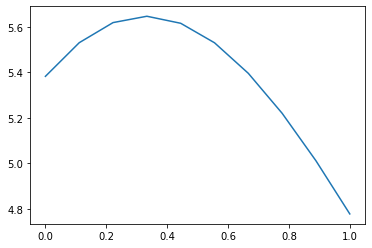

In [125]:
def u0(x):
    return x**2
  
y_true = u0(mesh_x).squeeze()
print(y_true.shape)
print(y_train.shape)

plt.plot(mesh_x.detach(), y_train.detach())
  
  

In [127]:
# Optimization
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

total_acc, total_loss=[], []
for epoch in range(1000):
    y_pred=model(x_train)
    print(y_pred.shape)
    print(y_true.shape)
    loss = criterion(y_pred,y_true)
    if epoch%500 == 0:
        print('loss', loss)
    optimizer.zero_grad()
    loss.backward(retain_graph=True) # back propagation
    optimizer.step()
    optimizer.zero_grad()
print(' - Training is complete')



    

torch.Size([10])
torch.Size([10])
loss tensor(24.2357, grad_fn=<MseLossBackward0>)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.